In [2]:
import numpy as np
import yaml
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt
import cv2 as cv
import shutil
import os
import torch
from ultralytics import YOLO

In [2]:
config = yaml.load(open('./configs/config.default.yaml'), Loader=yaml.FullLoader)

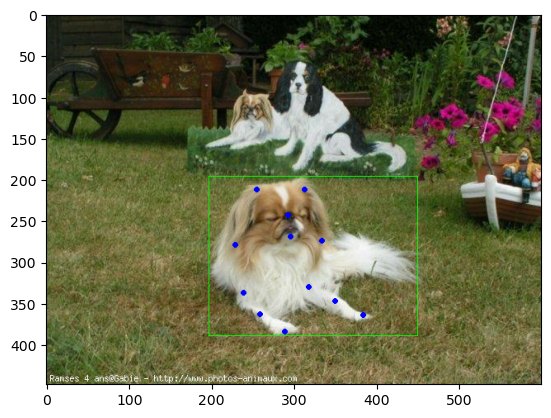

In [3]:
def draw_image_with_kp_and_bbox(path):
    '''
    Draw the keypoints of an image
    '''
    with open(config['json_path']) as infile:
        json_data = json.load(infile)

    json_dict = {'Images/'+i["img_path"]: i for i in json_data}
    img = cv.imread(str(path))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 

    kp = json_dict[path]['joints'] 
    bbox = json_dict[path]['img_bbox']

    x = bbox[0]
    y = bbox[1]
    width = bbox[2]
    height = bbox[3]

    cv.rectangle(img, (int(x), int(y)), (int(x+(width)), int(y+(height))), (0, 255, 0))

    for p in kp:
        x,y = int(p[0]), int(p[1])
        cv.circle(img, (x,y), 2, (0,0,255), 2)

    plt.imshow(img)

    return img, kp

image_path = 'Images/n02085782-Japanese_spaniel/n02085782_2914.jpg'
draw_image_with_kp_and_bbox(image_path);

In [4]:
class Preprocessing:
    def __init__(self) -> None:
        """
        Preprocessing is a class designed for formatting the raw data to
        be in design for YOLO v8 format for pose detection
        """
        self.json_dict = None
        self.classes = config['classes']

    def create_valid_dataset_with_annotation(self) -> None:
        """
        main method that handle calling other helper methods to copy and
        annotate an image and put it in the right folder
        """
        train, val = self.create_splits()
        
        for new_path, split in [(config['train'], train), (config['val'], val)]:
            for old_path in split:
                self.annotate_image(old_path, new_path)

    def create_splits(self) -> None:
        """
        helper method for spliting the data into training and validation sets
        """
        with open(config['json_path']) as infile:
            json_data = json.load(infile)

        self.json_dict = {'Images/'+i["img_path"]: i for i in json_data}
        paths = list(self.json_dict.keys())
        train, val = train_test_split(paths, test_size=.1, random_state=42)

        return train, val

    def annotate_image(self, old_path: str, new_path: str) -> None:
        """
        Helper method for creating annotation for an image and put it in the new path

        :param old_path: the path of the image in the row data
        :param new_path: the new path of the image in dataset dir
        """
        image_data = self.json_dict[old_path]

        image_name = old_path.split('/')[-1].split('.')[0]
        image_class = old_path.split('/')[1]
        class_idx = self.classes.index(image_class)

        image_width = image_data['img_width']
        image_height = image_data['img_height']

        bbox =  image_data['img_bbox']
        joints = image_data['joints']

        x_center = (bbox[0] + bbox[2]/2) / image_width
        y_center = (bbox[1] + bbox[3]/2) / image_height
        bbox_width = bbox[2] / image_width
        bbox_height = bbox[3] / image_height
        
        normalized_joints = ' '.join([f'{p[0]/image_width} {p[1]/image_height} {p[2]}' for p in joints])

        if os.path.exists(old_path):
            shutil.copy(old_path, new_path)

        
        with open(f'{new_path}{image_name}.txt', 'w') as f:
            f.write(f'{class_idx} {x_center} {y_center} {bbox_width} {bbox_height} {normalized_joints}')

In [39]:
Preprocessing().create_valid_dataset_with_annotation()

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.set_device(0)

In [6]:
# Load a model
model = YOLO('yolov8n-pose.pt')

results = model.train(data='./configs/dataset.yaml', epochs=20, imgsz=640)

Ultralytics YOLOv8.0.222 🚀 Python-3.11.4 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=./configs/dataset.yaml, epochs=20, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

train: Scanning M:\Projects\CV\Key_Point_Detection\dataset\train.cache... 11284 images, 0 backgrounds, 635 corrupt: 100%|██████████| 11284/11284 [00:00<?, ?it/s]

train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_1455.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_1492.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_1569.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_1617.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_2793.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_3208.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠


val: Scanning M:\Projects\CV\Key_Point_Detection\dataset\val.cache... 1254 images, 0 backgrounds, 61 corrupt: 100%|██████████| 1254/1254 [00:00<?, ?it/s]

val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02085620_1620.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02085620_3677.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02085782_143.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02085936_4271.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02085936_461.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02086079_16313.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_

Plotting labels to c:\Users\mahmoud\runs\pose\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=8.1e-05, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\Users\mahmoud\runs\pose\train6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.1G     0.8231      10.82     0.6911      4.909      1.355         24        640: 100%|██████████| 666/666 [02:02<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.39it/s]


                   all       1193       1193    0.00714      0.484     0.0121    0.00956          0          0          0          0

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.95G       0.78      9.376     0.6224      4.409      1.303         25        640: 100%|██████████| 666/666 [02:02<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.68it/s]


                   all       1193       1193    0.00714        0.9     0.0224     0.0183      0.317    0.00104   0.000291   3.92e-05

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.96G     0.7959       8.28     0.5606      4.066      1.297         25        640: 100%|██████████| 666/666 [01:55<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.62it/s]


                   all       1193       1193    0.00719      0.978     0.0263     0.0214    0.00128      0.184    0.00233   0.000452

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.98G     0.7811      7.514     0.5277      3.862      1.275         21        640: 100%|██████████| 666/666 [01:57<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.45it/s]


                   all       1193       1193     0.0993      0.144     0.0358     0.0296      0.295     0.0188    0.00794    0.00196

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.97G     0.7649      6.995     0.5089      3.724      1.256         23        640: 100%|██████████| 666/666 [02:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.70it/s]


                   all       1193       1193      0.492     0.0568     0.0497     0.0422      0.495     0.0206     0.0151    0.00375

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.97G     0.7486      6.707      0.495      3.613      1.242         19        640: 100%|██████████| 666/666 [01:50<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.80it/s]


                   all       1193       1193      0.354      0.106     0.0574     0.0493       0.35     0.0463     0.0183     0.0043

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.96G     0.7379      6.458     0.4826       3.51      1.237         25        640: 100%|██████████| 666/666 [01:50<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.87it/s]


                   all       1193       1193      0.448      0.108     0.0732     0.0634      0.434      0.068     0.0313    0.00802

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.97G     0.7257      6.282     0.4727      3.415      1.225         23        640: 100%|██████████| 666/666 [01:50<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.88it/s]


                   all       1193       1193      0.334      0.142     0.0944     0.0813      0.327     0.0821     0.0447     0.0111

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.96G      0.726      6.147     0.4649      3.333      1.222         17        640: 100%|██████████| 666/666 [01:50<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.80it/s]


                   all       1193       1193      0.299      0.173      0.103     0.0882      0.311      0.111     0.0592     0.0165

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.97G      0.722      6.037     0.4563      3.262       1.22         25        640: 100%|██████████| 666/666 [01:49<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.87it/s]


                   all       1193       1193      0.314       0.18       0.12      0.103      0.323      0.109      0.063     0.0175
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.02G     0.5911      4.969       0.47      3.301      1.191          9        640: 100%|██████████| 666/666 [01:49<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.83it/s]


                   all       1193       1193      0.239      0.197      0.134      0.116      0.222      0.139     0.0823     0.0227

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.96G     0.5575      4.745     0.4408      3.128      1.154          9        640: 100%|██████████| 666/666 [01:48<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.88it/s]


                   all       1193       1193        0.2      0.246      0.158      0.138      0.177      0.173      0.105     0.0321

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.95G     0.5458      4.605     0.4347      3.009      1.143          9        640: 100%|██████████| 666/666 [01:48<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.88it/s]


                   all       1193       1193      0.191      0.257      0.178      0.156      0.172      0.189      0.121     0.0377

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.96G     0.5318      4.473     0.4308      2.922      1.127          9        640: 100%|██████████| 666/666 [01:48<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.82it/s]


                   all       1193       1193      0.195      0.297      0.195      0.171      0.185      0.225      0.136     0.0434

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.94G     0.5233      4.393     0.4293       2.85       1.12          9        640: 100%|██████████| 666/666 [01:48<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.89it/s]


                   all       1193       1193      0.221      0.301      0.213      0.188      0.187       0.24      0.151     0.0485

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.95G     0.5163      4.305     0.4268      2.785       1.11          9        640: 100%|██████████| 666/666 [01:48<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.89it/s]


                   all       1193       1193      0.235      0.289      0.212      0.187      0.194      0.231      0.154     0.0502

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.94G     0.5044      4.214     0.4249      2.736      1.098          9        640: 100%|██████████| 666/666 [01:48<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.89it/s]


                   all       1193       1193      0.213      0.318      0.215       0.19      0.182      0.256      0.155     0.0532

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.95G     0.5033      4.178     0.4245      2.691        1.1          9        640: 100%|██████████| 666/666 [01:49<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:14<00:00,  2.67it/s]


                   all       1193       1193      0.211       0.33      0.235      0.208      0.171      0.269      0.171     0.0593

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.94G     0.4951      4.095     0.4237       2.65      1.092          9        640: 100%|██████████| 666/666 [01:46<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.80it/s]


                   all       1193       1193      0.216      0.337      0.238       0.21      0.187      0.265      0.172     0.0602

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.95G     0.4873      4.063     0.4239      2.622      1.084          9        640: 100%|██████████| 666/666 [01:47<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.84it/s]


                   all       1193       1193      0.216       0.32      0.241      0.213      0.183      0.262      0.179      0.062

20 epochs completed in 0.717 hours.
Optimizer stripped from c:\Users\mahmoud\runs\pose\train6\weights\last.pt, 7.8MB
Optimizer stripped from c:\Users\mahmoud\runs\pose\train6\weights\best.pt, 7.8MB

Validating c:\Users\mahmoud\runs\pose\train6\weights\best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.11.4 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-pose summary (fused): 187 layers, 3793256 parameters, 0 gradients, 11.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:09<00:00,  3.80it/s]


                   all       1193       1193      0.209      0.326      0.242      0.214      0.183      0.267      0.181     0.0626
           groenendael       1193          9      0.259      0.667       0.52      0.486      0.263      0.667      0.489      0.151
             Chihuahua       1193         16      0.306      0.375      0.317       0.29      0.308      0.375      0.288     0.0944
       Tibetan_mastiff       1193          9      0.633      0.199      0.307      0.277      0.148     0.0492      0.101     0.0432
  Bouvier_des_Flandres       1193         15        0.2      0.533      0.372       0.33      0.207      0.533      0.336      0.133
         Irish_terrier       1193          7          1          0      0.114     0.0907          1          0     0.0551     0.0127
        Dandie_Dinmont       1193         15      0.297      0.667      0.501      0.434      0.242      0.533      0.425      0.165
              Doberman       1193          8      0.119       0.25   

In [8]:
model = YOLO('runs/pose/train6/weights/last.pt')

results = model.train(resume=True, epochs=60, imgsz=640)

Ultralytics YOLOv8.0.222 🚀 Python-3.11.4 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=pose, mode=train, model=runs\pose\train6\weights\last.pt, data=./configs/dataset.yaml, epochs=20, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train63, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

train: Scanning M:\Projects\CV\Key_Point_Detection\dataset\train.cache... 11284 images, 0 backgrounds, 635 corrupt: 100%|██████████| 11284/11284 [00:00<?, ?it/s]

train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_1455.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_1492.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_1569.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_1617.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_2793.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\train\n02085620_3208.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
train: WARNING ⚠


val: Scanning M:\Projects\CV\Key_Point_Detection\dataset\val.cache... 1254 images, 0 backgrounds, 61 corrupt: 100%|██████████| 1254/1254 [00:00<?, ?it/s]

val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02085620_1620.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02085620_3677.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02085782_143.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02085936_4271.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02085936_461.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_Detection\dataset\val\n02086079_16313.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates []
val: WARNING ⚠️ M:\Projects\CV\Key_Point_

Plotting labels to c:\Users\mahmoud\runs\pose\train63\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=8.1e-05, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\Users\mahmoud\runs\pose\train63
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.97G     0.4955      4.078     0.4231      2.614      1.094          9        640: 100%|██████████| 666/666 [01:55<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:15<00:00,  2.44it/s]


                   all       1193       1193      0.213      0.344      0.243      0.215      0.182      0.288      0.178     0.0606

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.95G      0.509      4.125     0.4195      2.595      1.099          9        640: 100%|██████████| 666/666 [01:51<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.74it/s]


                   all       1193       1193      0.219      0.348      0.249      0.216      0.191      0.277      0.188     0.0597

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.94G     0.5145      4.158     0.4183      2.551       1.11          9        640: 100%|██████████| 666/666 [01:46<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.74it/s]


                   all       1193       1193      0.225      0.322      0.263      0.229      0.179      0.256       0.19     0.0609

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.95G     0.5175      4.095     0.4165      2.481       1.11          9        640: 100%|██████████| 666/666 [01:46<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.80it/s]


                   all       1193       1193      0.231      0.341      0.278      0.243      0.177      0.293      0.208      0.068

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.94G      0.508      4.016     0.4126      2.396      1.101          9        640: 100%|██████████| 666/666 [01:45<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.84it/s]


                   all       1193       1193      0.237      0.357      0.297       0.26      0.198      0.294      0.222     0.0763

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.95G     0.5015      3.937     0.4113      2.321      1.093          9        640: 100%|██████████| 666/666 [01:46<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.87it/s]


                   all       1193       1193       0.24      0.363      0.307      0.266      0.187        0.3      0.234     0.0808

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.93G     0.4912      3.867     0.4093      2.246      1.084          9        640: 100%|██████████| 666/666 [01:45<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.89it/s]


                   all       1193       1193      0.265      0.381      0.332      0.289      0.247      0.318      0.256     0.0914

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.94G     0.4883      3.798     0.4076      2.172      1.083          9        640: 100%|██████████| 666/666 [01:45<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:12<00:00,  2.94it/s]


                   all       1193       1193      0.271      0.362       0.34      0.299      0.227      0.324       0.27     0.0983

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.93G      0.481      3.737      0.407      2.123       1.08          9        640: 100%|██████████| 666/666 [01:46<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.81it/s]


                   all       1193       1193      0.289       0.39      0.355       0.31      0.264       0.33      0.274      0.104

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.94G     0.4723      3.658     0.4046      2.052      1.067          9        640: 100%|██████████| 666/666 [01:45<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.91it/s]


                   all       1193       1193      0.342      0.394      0.376      0.328      0.304      0.346      0.298       0.11
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/20         3G      0.459      3.596     0.4032      1.997      1.057          9        640: 100%|██████████| 666/666 [01:47<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.73it/s]


                   all       1193       1193      0.339      0.418      0.387      0.339      0.304      0.357      0.312      0.119

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.94G     0.4507      3.539     0.4024      1.949      1.049          9        640: 100%|██████████| 666/666 [01:45<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.87it/s]


                   all       1193       1193      0.314      0.441      0.388      0.341      0.274      0.382      0.314      0.118

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.93G     0.4474      3.502     0.4018      1.895      1.045          9        640: 100%|██████████| 666/666 [01:45<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.88it/s]


                   all       1193       1193      0.341      0.428      0.407      0.359      0.309      0.365      0.329      0.125

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.94G     0.4388      3.447     0.4004      1.858      1.036          9        640: 100%|██████████| 666/666 [01:46<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.88it/s]


                   all       1193       1193      0.332      0.438      0.408      0.359      0.289      0.381      0.333      0.131

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.93G     0.4331      3.433     0.4006      1.821      1.034          9        640: 100%|██████████| 666/666 [01:45<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:12<00:00,  2.93it/s]


                   all       1193       1193       0.37      0.435      0.421      0.371       0.34      0.377      0.347      0.137

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.94G     0.4324      3.391     0.3992      1.788      1.029          9        640: 100%|██████████| 666/666 [01:45<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.85it/s]


                   all       1193       1193       0.38      0.435      0.427      0.378      0.338      0.379      0.356      0.142

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.93G     0.4251      3.346     0.3979      1.766      1.022          9        640: 100%|██████████| 666/666 [01:45<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.88it/s]


                   all       1193       1193      0.397      0.429      0.437      0.387      0.347      0.387      0.361      0.146

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.94G     0.4285      3.325     0.3982      1.738      1.029          9        640: 100%|██████████| 666/666 [01:45<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.81it/s]


                   all       1193       1193      0.362      0.451       0.44      0.391      0.347      0.376      0.361      0.145

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.93G     0.4226      3.278      0.398       1.71      1.022          9        640: 100%|██████████| 666/666 [01:45<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.86it/s]


                   all       1193       1193      0.388      0.424      0.441       0.39      0.339      0.372      0.363      0.147

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.94G     0.4187      3.269     0.3985      1.689      1.018          9        640: 100%|██████████| 666/666 [01:46<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.82it/s]


                   all       1193       1193      0.377      0.458      0.447      0.396      0.348      0.372      0.364      0.149

20 epochs completed in 0.685 hours.
Optimizer stripped from c:\Users\mahmoud\runs\pose\train63\weights\last.pt, 7.8MB
Optimizer stripped from c:\Users\mahmoud\runs\pose\train63\weights\best.pt, 7.8MB

Validating c:\Users\mahmoud\runs\pose\train63\weights\best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.11.4 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-pose summary (fused): 187 layers, 3793256 parameters, 0 gradients, 11.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:10<00:00,  3.79it/s]


                   all       1193       1193      0.389      0.435      0.447      0.397      0.348      0.373      0.364      0.149
           groenendael       1193          9      0.442      0.778      0.749      0.678      0.381      0.667      0.534      0.182
             Chihuahua       1193         16      0.385      0.312      0.374      0.319      0.399      0.312      0.269      0.107
       Tibetan_mastiff       1193          9        0.2      0.333      0.449      0.387      0.212      0.333       0.39      0.103
  Bouvier_des_Flandres       1193         15      0.456      0.667      0.606      0.546       0.47        0.6      0.513      0.263
         Irish_terrier       1193          7      0.476      0.266      0.382      0.297      0.452      0.244      0.255     0.0725
        Dandie_Dinmont       1193         15      0.515        0.6      0.667      0.602      0.529        0.6      0.619      0.279
              Doberman       1193          8      0.313        0.5   

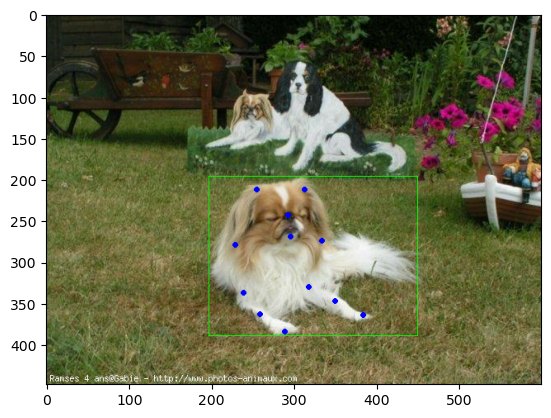

In [9]:
image_path = 'Images/n02085782-Japanese_spaniel/n02085782_2914.jpg'
draw_image_with_kp_and_bbox(image_path);

In [22]:
model.predict('Images/n02085782-Japanese_spaniel/n02085782_2914.jpg', save=True, conf=0.5)


image 1/1 m:\Projects\CV\Key_Point_Detection\Images\n02085782-Japanese_spaniel\n02085782_2914.jpg: 480x640 1 Japanese_spaniel, 10.2ms
Speed: 2.7ms preprocess, 10.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to c:\Users\mahmoud\runs\pose\train632


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: ultralytics.engine.results.Keypoints object
 masks: None
 names: {0: 'groenendael', 1: 'Chihuahua', 2: 'Tibetan_mastiff', 3: 'Bouvier_des_Flandres', 4: 'Irish_terrier', 5: 'Dandie_Dinmont', 6: 'Doberman', 7: 'bloodhound', 8: 'Chesapeake_Bay_retriever', 9: 'basenji', 10: 'borzoi', 11: 'Labrador_retriever', 12: 'Newfoundland', 13: 'Scotch_terrier', 14: 'English_foxhound', 15: 'Welsh_springer_spaniel', 16: 'silky_terrier', 17: 'Eskimo_dog', 18: 'Saluki', 19: 'toy_terrier', 20: 'cocker_spaniel', 21: 'flat-coated_retriever', 22: 'Tibetan_terrier', 23: 'Kerry_blue_terrier', 24: 'Rhodesian_ridgeback', 25: 'Yorkshire_terrier', 26: 'Blenheim_spaniel', 27: 'Irish_water_spaniel', 28: 'EntleBucher', 29: 'English_springer', 30: 'German_shepherd', 31: 'Old_English_sheepdog', 32: 'Gordon_setter', 33: 'American_Staffordshire_terrier', 34: 'black-and-tan_coonhound', 35: 'boxer', 36:

In [19]:
result = model('Images/n02085782-Japanese_spaniel/n02085782_2914.jpg')


image 1/1 m:\Projects\CV\Key_Point_Detection\Images\n02085782-Japanese_spaniel\n02085782_2914.jpg: 480x640 1 Japanese_spaniel, 38.1ms
Speed: 5.0ms preprocess, 38.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


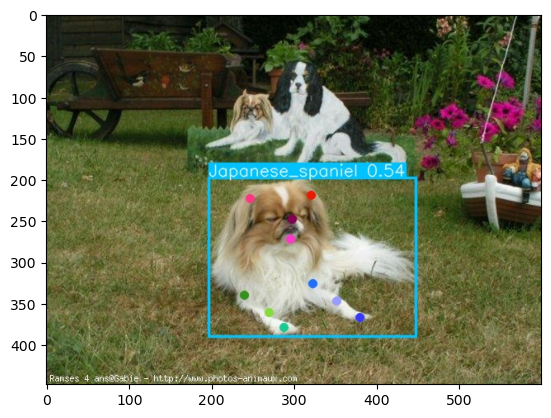

In [9]:
img = cv.imread('n02085782_2914.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 

plt.imshow(img)